In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)  

In [2]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [3]:
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

# Creating,training,testing and saving model

In [4]:
# Build the neural network, expand on top of nn.Module
'''

1. Read the Rules!
2. Construct a ReLU-activated neural network with four hidden layers with sizes [1000, 1000,
500, 200]. Note: you’ll have a fifth layer for your output logits, which you will have 10 of.
3. Train your network on MNIST or Fashion-MNIST (your choice, whatever is easier)
4. Prune away (set to zero) the k% of weights using weight and unit pruning for k in [0, 25,
50, 60, 70, 80, 90, 95, 97, 99]. Remember not to prune the weights leading to the output
logits.
5. Create a table or plot showing the percent sparsity (number of weights in your network
that are zero) versus percent accuracy with two curves (one for weight pruning and one
for unit pruning).
6. Make your code clean and readable. Add comments where needed.
'''


class AdaGradNetwork(nn.Module):
  def __init__(self):
    super(AdaGradNetwork, self).__init__()

    # define layers
    self.fc1 = nn.Linear(in_features=28*28, out_features=1000)
    self.fc2 = nn.Linear(in_features=1000, out_features=1000)
    self.fc3 = nn.Linear(in_features=1000, out_features=500)
    self.fc4 = nn.Linear(in_features=500, out_features=200)
    self.out = nn.Linear(in_features=200, out_features=10)

  # define forward function
  def forward(self, t):
    # fc1  make input 1 dimentional
    t = t.view(-1,28*28)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)
    
    # fc3
    t = self.fc3(t)
    t = F.relu(t)

    # fc4
    t = self.fc4(t)
    t = F.relu(t)
    
    # output
    t = self.out(t)

    return t

In [5]:
myNN=AdaGradNetwork()
print myNN

AdaGradNetwork(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)


In [6]:
loader = torch.utils.data.DataLoader(train_set, batch_size = 1000)
optimizer = optim.Adam(myNN.parameters(), lr=0.01)
creterion=nn.CrossEntropyLoss()  

In [7]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = myNN(inputs)
#         print outputs[0]
#         print outputs.size()
#         print  labels.size()
        loss = creterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 2.981
[1,    20] loss: 1.301
[1,    30] loss: 0.802
[1,    40] loss: 0.694
[1,    50] loss: 0.598
[1,    60] loss: 0.558
[2,    10] loss: 0.518
[2,    20] loss: 0.499
[2,    30] loss: 0.474
[2,    40] loss: 0.458
[2,    50] loss: 0.444
[2,    60] loss: 0.454
[3,    10] loss: 0.426
[3,    20] loss: 0.415
[3,    30] loss: 0.395
[3,    40] loss: 0.379
[3,    50] loss: 0.389
[3,    60] loss: 0.403
[4,    10] loss: 0.386
[4,    20] loss: 0.378
[4,    30] loss: 0.357
[4,    40] loss: 0.348
[4,    50] loss: 0.366
[4,    60] loss: 0.377
[5,    10] loss: 0.360
[5,    20] loss: 0.363
[5,    30] loss: 0.339
[5,    40] loss: 0.334
[5,    50] loss: 0.346
[5,    60] loss: 0.354
Finished Training


In [8]:
torch.save(myNN.state_dict(), "./nn5epochs.pt")

In [10]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=4)

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = myNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
myNN.load_state_dict(torch.load("./nn5epochs.pt"))

<All keys matched successfully>

# Unit Pruning

#### Calculate masks for first four layers for all percentiles

In [14]:
all_percentiles=[0, 25,50, 60, 70, 80, 90, 95, 97, 99]
all_percentiles_masks=[]

for perc in all_percentiles:
    masks=[]
    print perc
    for i,p in enumerate(myNN.parameters(),0):
#     print p.size()
        if len(p.size()) >1 and i<8:
            norms=torch.norm(p.data,dim=1)#l2 norms
            percentile=np.percentile(np.array(norms),perc)
            unit_mask=norms.abs()>percentile
            masks.append(unit_mask.float().view(-1,1).repeat([1,p.size()[1]]))
    all_percentiles_masks.append(masks)

0
25
50
60
70
80
90
95
97
99


#### Apply mask to each weights tensor and test accuracy for each percentile

In [16]:
zero_weights_count=[]
accuracy_count=[]
for masks in all_percentiles_masks:
    myNN.load_state_dict(torch.load("./nn5epochs.pt"))
    mcount=0
    zero_weights=0
    for i,p in enumerate(myNN.parameters(),0):
    #     print p.size()[0]
        if len(p.size()) >1 and i<8:
            zero_weights+=np.count_nonzero(all_percentiles_masks[0][mcount].numpy())-np.count_nonzero(masks[mcount].numpy())
            p.data=p.data*masks[mcount]
            mcount+=1
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = myNN(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    zero_weights_count.append(zero_weights)
    accuracy_count.append(100 * correct / total)
    print( "Number of zero weights: "+str(zero_weights))
    print(' Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Number of zero weights: 0
 Accuracy of the network on the 10000 test images: 84 %
Number of zero weights: 592716
 Accuracy of the network on the 10000 test images: 84 %
Number of zero weights: 1188716
 Accuracy of the network on the 10000 test images: 82 %
Number of zero weights: 1427116
 Accuracy of the network on the 10000 test images: 80 %
Number of zero weights: 1665516
 Accuracy of the network on the 10000 test images: 70 %
Number of zero weights: 1903916
 Accuracy of the network on the 10000 test images: 49 %
Number of zero weights: 2142316
 Accuracy of the network on the 10000 test images: 28 %
Number of zero weights: 2261516
 Accuracy of the network on the 10000 test images: 11 %
Number of zero weights: 2309196
 Accuracy of the network on the 10000 test images: 11 %
Number of zero weights: 2356876
 Accuracy of the network on the 10000 test images: 10 %


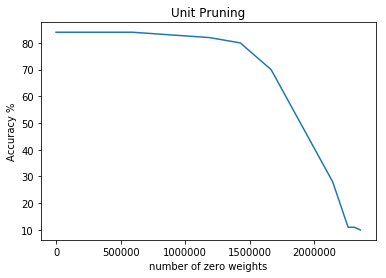

In [17]:
plt.plot(zero_weights_count,accuracy_count)
plt.xlabel("number of zero weights")
plt.title("Unit Pruning")
plt.ylabel("Accuracy %")
plt.show()

# Weight Pruning

#### get weights of first four layers and set mask matrix to zero for weight below given percentile 

In [22]:
myNN.load_state_dict(torch.load("./nn5epochs.pt"))

<All keys matched successfully>

In [23]:
all_weights =[]
for i,p in enumerate(myNN.parameters(),0):
#     print p.size()[0]
    if len(p.size()) >1 and i<8:
        all_weights+=list(p.cpu().data.abs().numpy().flatten())
#         print p.view(-1,p.size()[0]*p.size()[1]).
#     print i

In [24]:
threshholds=np.percentile(np.array(all_weights),[0, 25,
50, 60, 70, 80, 90, 95, 97, 99])

In [25]:
myNN.load_state_dict(torch.load("./nn5epochs.pt"))
masks_for_all_thresholds=[]
for threshold in threshholds:
    masks=[]
    for i,p in enumerate(myNN.parameters(),0):
    #     print p.size()[0]
        if len(p.size()) >1 and i<8:
            pruned_inds = p.data.abs() > threshold
            masks.append(pruned_inds.float())
    masks_for_all_thresholds.append(masks)

#### Apply mask to each weights tensor and test accuracy for each percentile

In [26]:
zero_weights_count2=[]
accuracy_count2=[]
for masks in masks_for_all_thresholds:
    myNN.load_state_dict(torch.load("./nn5epochs.pt"))
    mcount=0
    zero_weights=0
    for i,p in enumerate(myNN.parameters(),0):
    #     print p.size()[0]
        if len(p.size()) >1 and i<8:
            zero_weights+=np.count_nonzero(masks_for_all_thresholds[0][mcount].numpy())-np.count_nonzero(masks[mcount].numpy())
            p.data=p.data*masks[mcount]
            mcount+=1
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = myNN(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    zero_weights_count2.append(zero_weights)
    accuracy_count2.append( 100 * correct / total)

    print( "Number of zero weights: "+str(zero_weights))
    print(' Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    

Number of zero weights: 0
 Accuracy of the network on the 10000 test images: 84 %
Number of zero weights: 595999
 Accuracy of the network on the 10000 test images: 83 %
Number of zero weights: 1191999
 Accuracy of the network on the 10000 test images: 82 %
Number of zero weights: 1430399
 Accuracy of the network on the 10000 test images: 81 %
Number of zero weights: 1668799
 Accuracy of the network on the 10000 test images: 79 %
Number of zero weights: 1907200
 Accuracy of the network on the 10000 test images: 74 %
Number of zero weights: 2145599
 Accuracy of the network on the 10000 test images: 66 %
Number of zero weights: 2264799
 Accuracy of the network on the 10000 test images: 60 %
Number of zero weights: 2312479
 Accuracy of the network on the 10000 test images: 48 %
Number of zero weights: 2360159
 Accuracy of the network on the 10000 test images: 19 %


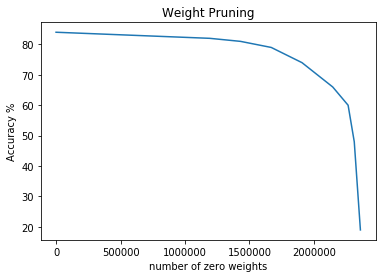

In [27]:
plt.plot(zero_weights_count2,accuracy_count2)
plt.xlabel("number of zero weights")
plt.title("Weight Pruning")
plt.ylabel("Accuracy %")
plt.show()

# Plot to get comparision of unit and weight pruning 

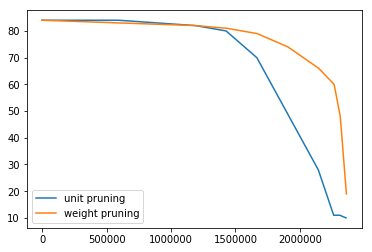

In [35]:
plt.plot(zero_weights_count,accuracy_count,label="unit pruning")
plt.plot(zero_weights_count2,accuracy_count2,label='weight pruning')
plt.legend()
plt.show()